In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tabulate
import tensorflow as tf

from ai_utils import metrics
from datetime import datetime
from IPython.display import SVG, HTML, display
from keras.layers import Dense, LSTM
from keras.models import Sequential
from keras.optimizers import Adam
from keras_lr_finder import LRFinder
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [2]:
_file = pd.ExcelFile("./Mucuri_novo_semNaN_torre150m.xlsx")
df = _file.parse("Dados anemo")

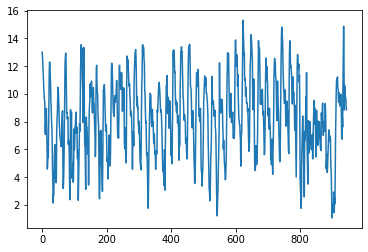

In [3]:
plt.plot(df.v_anemo2)
plt.show()

In [4]:
train_data_1 = df[pd.to_datetime(df["Data"]) <= datetime(year=2015, month=12, day=22)]
train_data_2 = df[
    (pd.to_datetime(df["Data"]) == datetime(year=2015, month=12, day=23))
    & (df["hora"] <= 11)
]

X_train_data = pd.concat([train_data_1, train_data_2]).drop(["Data", "dia", "mês", "ano", "hora"], axis=1)

In [5]:
test_data_1 = df[
    (pd.to_datetime(df["Data"]) == datetime(year=2015, month=12, day=23))
    & (df["hora"] >= 12)
]
test_data_2 = df[
    (pd.to_datetime(df["Data"]) >= datetime(year=2015, month=12, day=24))
    & (pd.to_datetime(df["Data"]) <= datetime(year=2015, month=12, day=30))
]
test_data_3 = df[
    (pd.to_datetime(df["Data"]) == datetime(year=2015, month=12, day=31))
    & (df["hora"] <= 13)
]

X_test_data = pd.concat([test_data_1, test_data_2, test_data_3]).drop(["Data", "dia", "mês", "ano", "hora"], axis=1)

In [6]:
def generate_Y(X, number_of_hours=1):
    
    X = X.copy()
    
    try:
        Y = X.v_anemo2
    except:
        Y = X[:,0]

    Y = Y[number_of_hours:]
    X = X[:len(X)-number_of_hours]
    
    return X, Y

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_data = scaler.fit_transform(X_train_data)
X_test_data = scaler.fit_transform(X_test_data)

In [8]:
X_train, Y_train = generate_Y(X_train_data)

In [9]:
X_test, Y_test = generate_Y(X_test_data)

In [10]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, 5))
X_test = np.reshape(X_test, (X_test.shape[0], 1, 5))

In [11]:
class MucuriModelLSTM:
    
    def __init__(self):
        
        self.model = None
        self._build_model()
        
    def _build_model(self):
        
        if self.model is None:
            
            self.model = Sequential()
            self.model.add(LSTM(4, input_shape=(1, 5)))
            self.model.add(Dense(1))
            self.model.compile(loss="mean_squared_error", optimizer=Adam(0.013), metrics=["mse", "mae"])
            
    def train(self, X, Y, X_test=None, Y_test=None, epochs=50, verbose=0):
        
        return self.model.fit(
            X,
            Y,
            validation_data=(X_test, Y_test) if X_test is not None and Y_test is not None else None,
            verbose=verbose,
            batch_size=64,
            epochs=epochs,
        )
    
    def predict(self, X):
        
        return self.model.predict(X)

In [12]:
model = MucuriModelLSTM()

In [13]:
# %%capture

lr_finder = LRFinder(model.model)
lr_finder.find(X_train, Y_train, start_lr=0.01, end_lr=0.015, epochs=300)

Epoch 1/300
549/549 [==============================] - 0s 381us/step - loss: 0.2292 - mse: 0.2292 - mae: 0.4251
Epoch 2/300
549/549 [==============================] - 0s 35us/step - loss: 0.0810 - mse: 0.0810 - mae: 0.2345
Epoch 3/300
549/549 [==============================] - 0s 25us/step - loss: 0.0488 - mse: 0.0488 - mae: 0.1804
Epoch 4/300
549/549 [==============================] - 0s 34us/step - loss: 0.0471 - mse: 0.0471 - mae: 0.1756
Epoch 5/300
549/549 [==============================] - 0s 27us/step - loss: 0.0391 - mse: 0.0391 - mae: 0.1613
Epoch 6/300
549/549 [==============================] - 0s 28us/step - loss: 0.0366 - mse: 0.0366 - mae: 0.1572
Epoch 7/300
549/549 [==============================] - 0s 31us/step - loss: 0.0340 - mse: 0.0340 - mae: 0.1511
Epoch 8/300
549/549 [==============================] - 0s 33us/step - loss: 0.0310 - mse: 0.0310 - mae: 0.1437
Epoch 9/300
549/549 [==============================] - 0s 29us/step - loss: 0.0281 - mse: 0.0281 - mae: 0.1366


549/549 [==============================] - 0s 26us/step - loss: 0.0082 - mse: 0.0082 - mae: 0.0706
Epoch 75/300
549/549 [==============================] - 0s 23us/step - loss: 0.0082 - mse: 0.0082 - mae: 0.0709
Epoch 76/300
549/549 [==============================] - 0s 21us/step - loss: 0.0082 - mse: 0.0082 - mae: 0.0708
Epoch 77/300
549/549 [==============================] - 0s 26us/step - loss: 0.0083 - mse: 0.0083 - mae: 0.0714
Epoch 78/300
549/549 [==============================] - 0s 25us/step - loss: 0.0082 - mse: 0.0082 - mae: 0.0709
Epoch 79/300
549/549 [==============================] - 0s 25us/step - loss: 0.0082 - mse: 0.0082 - mae: 0.0701
Epoch 80/300
549/549 [==============================] - 0s 25us/step - loss: 0.0081 - mse: 0.0081 - mae: 0.0708
Epoch 81/300
549/549 [==============================] - 0s 28us/step - loss: 0.0082 - mse: 0.0082 - mae: 0.0710
Epoch 82/300
549/549 [==============================] - 0s 25us/step - loss: 0.0082 - mse: 0.0082 - mae: 0.0709
Epoch

549/549 [==============================] - 0s 32us/step - loss: 0.0078 - mse: 0.0078 - mae: 0.0691
Epoch 147/300
549/549 [==============================] - 0s 28us/step - loss: 0.0078 - mse: 0.0078 - mae: 0.0695
Epoch 148/300
549/549 [==============================] - 0s 27us/step - loss: 0.0079 - mse: 0.0079 - mae: 0.0701
Epoch 149/300
549/549 [==============================] - 0s 27us/step - loss: 0.0079 - mse: 0.0079 - mae: 0.0696
Epoch 150/300
549/549 [==============================] - 0s 22us/step - loss: 0.0079 - mse: 0.0079 - mae: 0.0695
Epoch 151/300
549/549 [==============================] - 0s 22us/step - loss: 0.0081 - mse: 0.0081 - mae: 0.0700
Epoch 152/300
549/549 [==============================] - 0s 27us/step - loss: 0.0080 - mse: 0.0080 - mae: 0.0707
Epoch 153/300
549/549 [==============================] - 0s 28us/step - loss: 0.0080 - mse: 0.0080 - mae: 0.0701
Epoch 154/300
549/549 [==============================] - 0s 29us/step - loss: 0.0079 - mse: 0.0079 - mae: 0.07

549/549 [==============================] - 0s 23us/step - loss: 0.0081 - mse: 0.0081 - mae: 0.0701
Epoch 219/300
549/549 [==============================] - 0s 27us/step - loss: 0.0078 - mse: 0.0078 - mae: 0.0702
Epoch 220/300
549/549 [==============================] - 0s 27us/step - loss: 0.0074 - mse: 0.0074 - mae: 0.0671
Epoch 221/300
549/549 [==============================] - 0s 26us/step - loss: 0.0074 - mse: 0.0074 - mae: 0.0666
Epoch 222/300
549/549 [==============================] - 0s 26us/step - loss: 0.0073 - mse: 0.0073 - mae: 0.0669
Epoch 223/300
549/549 [==============================] - 0s 26us/step - loss: 0.0073 - mse: 0.0073 - mae: 0.0669
Epoch 224/300
549/549 [==============================] - 0s 28us/step - loss: 0.0073 - mse: 0.0073 - mae: 0.0662
Epoch 225/300
549/549 [==============================] - 0s 25us/step - loss: 0.0073 - mse: 0.0073 - mae: 0.0667
Epoch 226/300
549/549 [==============================] - 0s 24us/step - loss: 0.0073 - mse: 0.0073 - mae: 0.06

549/549 [==============================] - 0s 25us/step - loss: 0.0069 - mse: 0.0069 - mae: 0.0648
Epoch 291/300
549/549 [==============================] - 0s 27us/step - loss: 0.0072 - mse: 0.0072 - mae: 0.0660
Epoch 292/300
549/549 [==============================] - 0s 26us/step - loss: 0.0072 - mse: 0.0072 - mae: 0.0671
Epoch 293/300
549/549 [==============================] - 0s 25us/step - loss: 0.0070 - mse: 0.0070 - mae: 0.0640
Epoch 294/300
549/549 [==============================] - 0s 26us/step - loss: 0.0070 - mse: 0.0070 - mae: 0.0647
Epoch 295/300
549/549 [==============================] - 0s 27us/step - loss: 0.0069 - mse: 0.0069 - mae: 0.0642
Epoch 296/300
549/549 [==============================] - 0s 25us/step - loss: 0.0069 - mse: 0.0069 - mae: 0.0645
Epoch 297/300
549/549 [==============================] - 0s 23us/step - loss: 0.0070 - mse: 0.0070 - mae: 0.0655
Epoch 298/300
549/549 [==============================] - 0s 22us/step - loss: 0.0070 - mse: 0.0070 - mae: 0.06

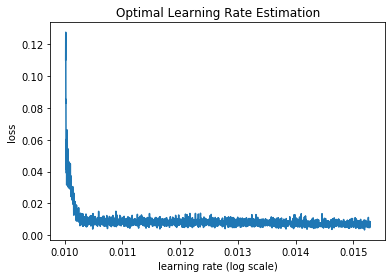

In [14]:
lr_finder.plot_loss()
plt.title(f"Optimal Learning Rate Estimation")
plt.xscale('linear')
plt.show()

In [15]:
training_history = model.train(X_train, Y_train, X_test, Y_test, epochs=100, verbose=1)

Train on 549 samples, validate on 193 samples
Epoch 1/100
549/549 [==============================] - 0s 114us/step - loss: 0.1427 - mse: 0.1427 - mae: 0.3107 - val_loss: 0.1426 - val_mse: 0.1426 - val_mae: 0.3256
Epoch 2/100
549/549 [==============================] - 0s 22us/step - loss: 0.0601 - mse: 0.0601 - mae: 0.1963 - val_loss: 0.0395 - val_mse: 0.0395 - val_mae: 0.1630
Epoch 3/100
549/549 [==============================] - 0s 32us/step - loss: 0.0381 - mse: 0.0381 - mae: 0.1601 - val_loss: 0.0502 - val_mse: 0.0502 - val_mae: 0.1867
Epoch 4/100
549/549 [==============================] - 0s 32us/step - loss: 0.0264 - mse: 0.0264 - mae: 0.1298 - val_loss: 0.0305 - val_mse: 0.0305 - val_mae: 0.1440
Epoch 5/100
549/549 [==============================] - 0s 28us/step - loss: 0.0192 - mse: 0.0192 - mae: 0.1127 - val_loss: 0.0344 - val_mse: 0.0344 - val_mae: 0.1528
Epoch 6/100
549/549 [==============================] - 0s 27us/step - loss: 0.0144 - mse: 0.0144 - mae: 0.0926 - val_loss: 

Epoch 50/100
549/549 [==============================] - 0s 29us/step - loss: 0.0086 - mse: 0.0086 - mae: 0.0727 - val_loss: 0.0134 - val_mse: 0.0134 - val_mae: 0.0988
Epoch 51/100
549/549 [==============================] - 0s 25us/step - loss: 0.0084 - mse: 0.0084 - mae: 0.0715 - val_loss: 0.0136 - val_mse: 0.0136 - val_mae: 0.0993
Epoch 52/100
549/549 [==============================] - 0s 23us/step - loss: 0.0084 - mse: 0.0084 - mae: 0.0720 - val_loss: 0.0116 - val_mse: 0.0116 - val_mae: 0.0904
Epoch 53/100
549/549 [==============================] - 0s 24us/step - loss: 0.0085 - mse: 0.0085 - mae: 0.0715 - val_loss: 0.0156 - val_mse: 0.0156 - val_mae: 0.1074
Epoch 54/100
549/549 [==============================] - 0s 26us/step - loss: 0.0084 - mse: 0.0084 - mae: 0.0719 - val_loss: 0.0133 - val_mse: 0.0133 - val_mae: 0.0982
Epoch 55/100
549/549 [==============================] - 0s 26us/step - loss: 0.0083 - mse: 0.0083 - mae: 0.0716 - val_loss: 0.0128 - val_mse: 0.0128 - val_mae: 0.095

549/549 [==============================] - 0s 27us/step - loss: 0.0080 - mse: 0.0080 - mae: 0.0704 - val_loss: 0.0115 - val_mse: 0.0115 - val_mae: 0.0910
Epoch 100/100
549/549 [==============================] - 0s 26us/step - loss: 0.0080 - mse: 0.0080 - mae: 0.0703 - val_loss: 0.0114 - val_mse: 0.0114 - val_mae: 0.0905


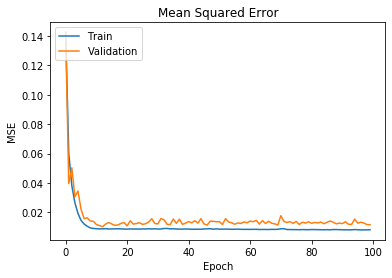

In [16]:
plt.plot(training_history.history["mse"])
plt.plot(training_history.history["val_mse"])
plt.title("Mean Squared Error")
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

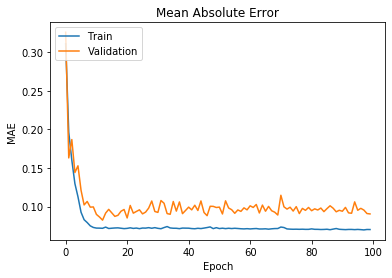

In [17]:
plt.plot(training_history.history["mae"])
plt.plot(training_history.history["val_mae"])
plt.title("Mean Absolute Error")
plt.ylabel("MAE")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

In [18]:
def predict(X, number_of_hours):
  
    assert number_of_hours > 0

    result = None
    input_data = X.copy()
    
    for hour in range(number_of_hours):
        
        predictions = np.array([model.predict([[value]])[0] for value in input_data])
        input_data = input_data[1:]
        
        # TODO: melhorar esse assign na coluna usando alguma função do numpy
        for line in range(len(input_data)):
            input_data[line][0][0] = predictions[line]

        result = predictions
        
    return result

In [19]:
def R_squared(y_true, y_pred):
    
    numpy_ = type(y_true).__name__ == 'ndarray'

    if(numpy_):
        y_true_mean = y_true.mean()
        y_pred_mean = y_pred.mean()

        sum_num = np.sum((y_pred-y_pred_mean)*y_true)
        numerator = np.square(sum_num)

        denominator = np.sum(np.square(y_pred - y_pred_mean)) \
            * np.sum(np.square(y_true - y_true_mean))
    
    else:
        y_true_mean = K.mean(y_true)
        y_pred_mean = K.mean(y_pred)

        numerator = K.square(K.sum((y_pred-y_pred_mean)*y_true))
        denominator = K.sum(K.square(y_pred - y_pred_mean))*K.sum(K.square(y_true - y_true_mean))

    R2 = numerator/denominator
    
    return R2

In [20]:
def pearson_r(y_true, y_pred):

    numpy_ = type(y_true).__name__ == 'ndarray'

    if(numpy_):
        y_true_mean = y_true.mean()
        y_pred_mean = y_pred.mean()

        diff_yt = y_true - y_true_mean
        diff_yp = y_pred - y_pred_mean

        numerator = np.sum((diff_yt) * (diff_yp))
        denominator = np.sqrt(np.sum(np.square(diff_yt))) * np.sqrt(np.sum(np.square(diff_yp)))
    else:

        y_true_mean = K.mean(y_true)
        y_pred_mean = K.mean(y_pred)

        diff_yt = y_true - y_true_mean
        diff_yp = y_pred - y_pred_mean

        numerator = K.sum((diff_yt) * (diff_yp))
        denominator = K.sqrt(K.sum(K.square(diff_yt))) * K.sqrt(K.sum(K.square(diff_yp)))

    r = numerator/denominator

    return r

In [21]:
def fac2(y_true, y_pred, to_numpy=False):
    min_ = 0.5
    max_ = 2

    division = tf.math.divide_no_nan(y_pred, y_true)

    greater_min = tf.greater_equal(division, min_)
    less_max = tf.less_equal(division, max_)

    res = tf.equal(greater_min, less_max)
    res = tf.cast(res, tf.float32)

    fac_2 = tf.reduce_mean(res)

    return K.get_value(fac_2) if to_numpy else fac_2

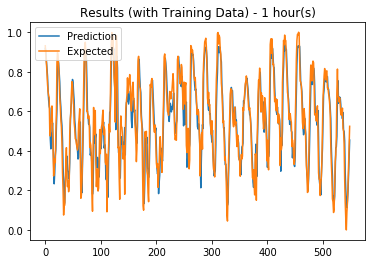

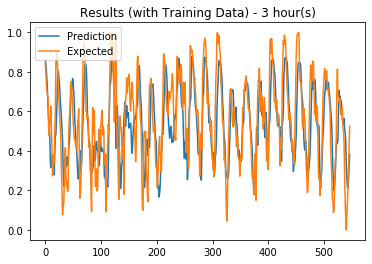

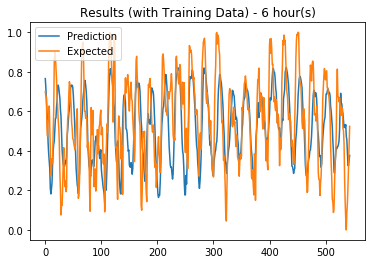

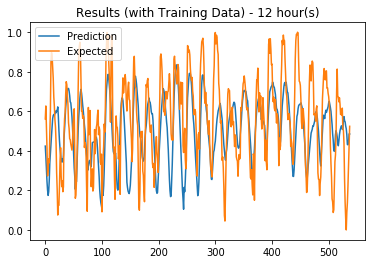

In [22]:
for hour in [1, 3, 6, 12]:
    prediction = predict(X_train, hour)
    _, expected_results = generate_Y(X_train_data, hour)
    
    if hour == 1:
        
        training_history.history["r_train"] = pearson_r(expected_results, prediction)
        training_history.history["r2_train"] = R_squared(expected_results, prediction)
        training_history.history["fac2_train"] = fac2(expected_results, prediction)
    
    plt.plot(prediction)
    plt.plot(expected_results)
    plt.title(f"Results (with Training Data) - {hour} hour(s)")
    plt.legend(["Prediction", "Expected"], loc="upper left")
    plt.show()

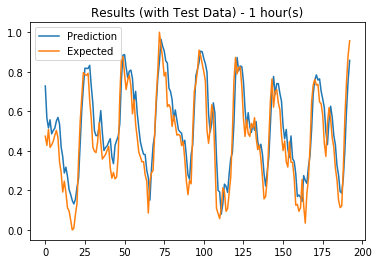

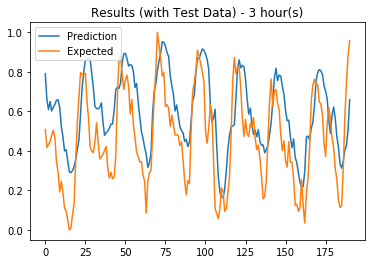

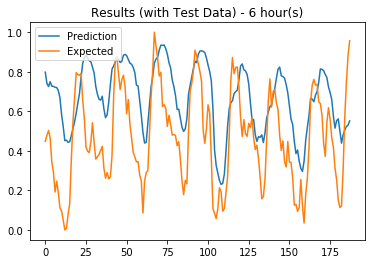

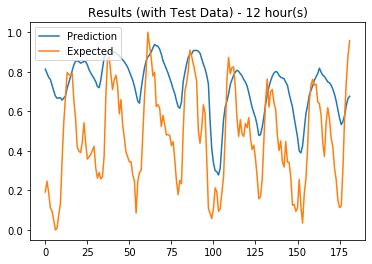

In [23]:
for hour in [1, 3, 6, 12]:
    prediction = predict(X_test, hour)
    _, expected_results = generate_Y(X_test_data, hour)
    
    if hour == 1:
        
        training_history.history["r_test"] = pearson_r(expected_results, prediction)
        training_history.history["r2_test"] = R_squared(expected_results, prediction)
        training_history.history["fac2_test"] = fac2(expected_results, prediction)
    
    plt.plot(prediction)
    plt.plot(expected_results)
    plt.title(f"Results (with Test Data) - {hour} hour(s)")
    plt.legend(["Prediction", "Expected"], loc="upper left")
    plt.show()

In [24]:
table = [
    ["Metric",],
    ["MSE training",],
    ["MSE validation",],
    ["MAE training",],
    ["MAE validation",],
    ["R training",],
    ["R test",],
    ["R2 training",],
    ["R2 test",],
    ["fac2 training",],
    ["fac2 test",],
]
    
table[0].append("Value")
table[1].append(min(training_history.history['mse']))
table[2].append(min(training_history.history['val_mse']))
table[3].append(min(training_history.history['mae']))
table[4].append(min(training_history.history['val_mae']))
table[5].append(training_history.history['r_train'])
table[6].append(training_history.history['r_test'])
table[7].append(training_history.history['r2_train'])
table[8].append(training_history.history['r2_test'])
table[9].append(training_history.history['fac2_train'])
table[10].append(training_history.history['fac2_test'])
    
display(HTML(tabulate.tabulate(table, tablefmt="html", headers="firstrow")))

Metric,Value
MSE training,0.00790326
MSE validation,0.0101413
MAE training,0.0697901
MAE validation,0.0824316
R training,-1.37588e-16
R test,2.30436e-17
R2 training,3.19596e-08
R2 test,8.52027e-10
fac2 training,0.743584
fac2 test,0.643051
